<a href="https://colab.research.google.com/github/AnishBehera05/Predictive_analysis_using_ML/blob/main/Predicting_Apple_Stock_Prices_with_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA Mean Squared Error: 4.821742869409581


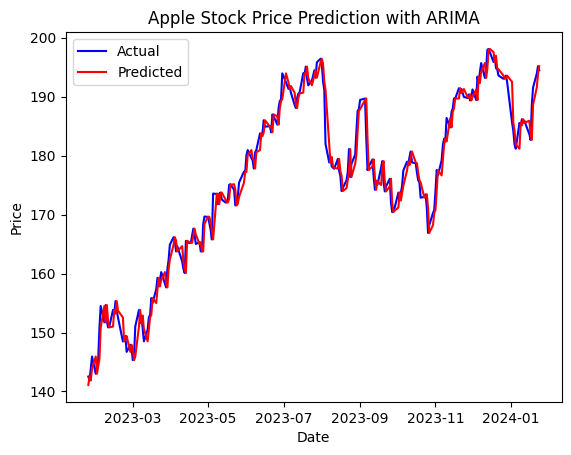

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load Apple stock price data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# ARIMA model
model = ARIMA(train['Close'], order=(0, 1, 0))
arima_model = model.fit()

# Predictions
history = [x for x in train['Close']]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(0, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['Close'].iloc[t]
    history.append(obs)

# Evaluate ARIMA model
error = mean_squared_error(test['Close'], predictions)
print('ARIMA Mean Squared Error:', error)

# Visualize predictions
plt.plot(test.index, test['Close'], color='blue', label='Actual')
plt.plot(test.index, predictions, color='red', label='Predicted')
plt.title('Apple Stock Price Prediction with ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test on each segment
def adf_with_breaks(data, maxlag=1):
    # Detect breakpoints (you can use your preferred method here)
    breakpoints = [0, len(data)]

    # Perform ADF test for each segment
    for i in range(len(breakpoints) - 1):
        segment = data[breakpoints[i]:breakpoints[i+1]]
        result = adfuller(segment, maxlag=maxlag)
        print(f"Segment {i+1}:")
        print(f"ADF Statistic: {result[0]}")
        print(f"p-value: {result[1]}")
        print("Critical Values:")
        for key, value in result[4].items():
            print(f"\t{key}: {value}")

# Apply ADF with structural breaks to the entire data
adf_with_breaks(data['Close'])


Segment 1:
ADF Statistic: -1.2423303504050567
p-value: 0.6551264979059416
Critical Values:
	1%: -3.4355629707955395
	5%: -2.863842063387667
	10%: -2.567995644141416


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

# Load Apple stock price data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Differencing to make the data stationary
data_diff = data['Close'].diff().dropna()

# Rerun the ADF test on the differenced data
adf_result = adfuller(data_diff)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')


ADF Statistic: -36.69292435677757
p-value: 0.0
Critical Values:
	1%: -3.4355671297788666
	5%: -2.8638438984080117
	10%: -2.5679966213893057


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from itertools import product

# Load Apple stock price data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Define the p, d, and q parameters range
p_values = range(0, 3)  # considering values 0, 1, 2 for p
d_values = range(0, 2)  # considering values 0, 1 for d
q_values = range(0, 3)  # considering values 0, 1, 2 for q

# Grid search for ARIMA parameters
best_mse = float("inf")
best_order = None

for p, d, q in product(p_values, d_values, q_values):
    order = (p, d, q)
    history = [x for x in train['Close']]
    predictions = []

    try:
        # Fit ARIMA model
        for t in range(len(test)):
            model = ARIMA(history, order=order)
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test['Close'].iloc[t]
            history.append(obs)

        # Calculate MSE
        error = mean_squared_error(test['Close'], predictions)

        # Update best parameters if necessary
        if error < best_mse:
            best_mse = error
            best_order = order

        print(f'ARIMA{order} MSE: {error}')

    except:
        continue

print('Best ARIMA Order:', best_order)
print('Best ARIMA MSE:', best_mse)


ARIMA(0, 0, 0) MSE: 3436.782606141768


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 1) MSE: 903.9820105623951


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 2) MSE: 305.4282265120928
ARIMA(0, 1, 0) MSE: 4.821742869409581
ARIMA(0, 1, 1) MSE: 4.882428385348505
ARIMA(0, 1, 2) MSE: 4.890958996582087
ARIMA(1, 0, 0) MSE: 4.8438801897443176
ARIMA(1, 0, 1) MSE: 4.9029048105994395
ARIMA(1, 0, 2) MSE: 4.91100933677429
ARIMA(1, 1, 0) MSE: 4.878443852617151
ARIMA(1, 1, 1) MSE: 4.893174830668326
ARIMA(1, 1, 2) MSE: 4.894862033705271
ARIMA(2, 0, 0) MSE: 4.899077976281072
ARIMA(2, 0, 1) MSE: 4.916438267298217
ARIMA(2, 0, 2) MSE: 4.915194091444199
ARIMA(2, 1, 0) MSE: 4.8877711309329825


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) MSE: 4.903649853043176


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

ARIMA(2, 1, 2) MSE: 4.907773816063585
Best ARIMA Order: (0, 1, 0)
Best ARIMA MSE: 4.821742869409581


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Load Apple stock price data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Function to perform the ADF test
def adf_test(series, start_idx, end_idx):
    adf_result = adfuller(series[start_idx:end_idx])
    return adf_result[1]  # Returning the p-value

# Function to find breakpoints using the ADF test
def find_breakpoints(data, window_size=50, significance_level=0.05):
    breakpoints = []
    num_points = len(data)
    start_idx = 0
    while start_idx < num_points:
        end_idx = min(start_idx + window_size, num_points)
        p_value = adf_test(data['Close'], start_idx, end_idx)
        if p_value < significance_level:
            breakpoints.append((data.index[start_idx], p_value))
            start_idx = end_idx
        else:
            start_idx += 1
    return breakpoints

# Find breakpoints in the data
breakpoints = find_breakpoints(data)

# Print breakpoints
print("Breakpoints detected:")
for point in breakpoints:
    print("Date:", point[0], "P-value:", point[1])


Breakpoints detected:
Date: 2019-04-17 00:00:00 P-value: 0.041958886848325674
Date: 2019-06-28 00:00:00 P-value: 0.03951478675946553
Date: 2019-12-09 00:00:00 P-value: 0.048386323786309304
Date: 2020-07-29 00:00:00 P-value: 0.044782003966790725
Date: 2021-03-16 00:00:00 P-value: 0.037773275238149114
Date: 2021-07-01 00:00:00 P-value: 0.027041834015634706
Date: 2022-01-31 00:00:00 P-value: 0.019481706589444304
Date: 2022-05-04 00:00:00 P-value: 0.011529294316044233
Date: 2022-09-12 00:00:00 P-value: 0.01520526940348121
Date: 2023-07-28 00:00:00 P-value: 0.024429531644791638
Date: 2023-10-26 00:00:00 P-value: 0.035105682686717946
Date: 2024-01-17 00:00:00 P-value: 2.2682091213260942e-10


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/di

ARIMAX Mean Squared Error: 0.027386170364045344


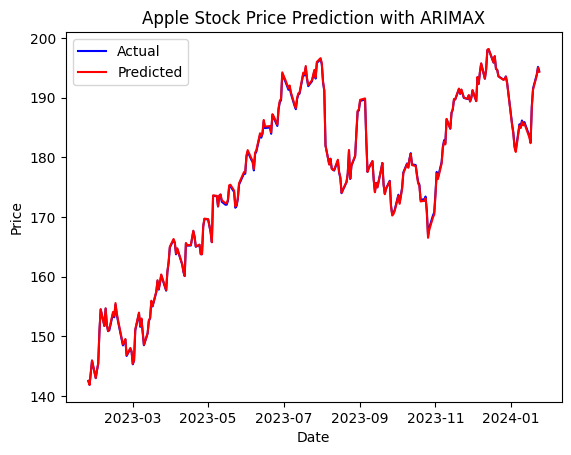

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load Apple stock price data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Add exogenous variables for the events
data['Settlement_Royalty_Dispute'] = np.where(data.index == '2019-04-17', 1, 0)
data['Trade_Tensions_Escalation'] = np.where(data.index == '2019-06-28', 1, 0)
data['US_China_Trade_Concerns'] = np.where(data.index == '2019-12-09', 1, 0)
data['Strong_Earnings_Report'] = np.where(data.index == '2020-07-29', 1, 0)
data['Disappointment_Over_iPhone_Sales'] = np.where(data.index == '2021-03-16', 1, 0)
data['iPhone_13_Launch_Delay'] = np.where(data.index == '2021-07-01', 1, 0)
data['Class_Action_Lawsuit'] = np.where(data.index == '2022-01-31', 1, 0)
data['Supply_Chain_Challenges'] = np.where(data.index == '2022-05-04', 1, 0)
data['US_China_Semiconductor_Curbs'] = np.where(data.index == '2022-09-12', 1, 0)
data['Technology_Sector_Gains'] = np.where(data.index == '2023-07-28', 1, 0)
data['Subdued_Holiday_Quarter_Forecast'] = np.where(data.index == '2023-10-26', 1, 0)
data['Return_of_Huawei_and_Foldable_Phones'] = np.where(data.index == '2024-01-17', 1, 0)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Fit ARIMAX model
exog_train = train.drop(columns=['Close'])
exog_test = test.drop(columns=['Close'])

model = ARIMA(train['Close'], exog=exog_train, order=(1, 2, 2))
arimax_model = model.fit()

# Predictions
predictions = arimax_model.forecast(steps=len(test), exog=exog_test)

# Evaluate ARIMAX model
error = mean_squared_error(test['Close'], predictions)
print('ARIMAX Mean Squared Error:', error)

# Visualize predictions
plt.plot(test.index, test['Close'], color='blue', label='Actual')
plt.plot(test.index, predictions, color='red', label='Predicted')
plt.title('Apple Stock Price Prediction with ARIMAX')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/di

Iteration:      1,   Func. Count:      7,   Neg. LLF: 714995681.8753934
Iteration:      2,   Func. Count:     21,   Neg. LLF: -1453.8566219196714
Iteration:      3,   Func. Count:     30,   Neg. LLF: 6547200.435798273
Iteration:      4,   Func. Count:     43,   Neg. LLF: 2714857214.037305
Iteration:      5,   Func. Count:     51,   Neg. LLF: 7691.843414241255
Iteration:      6,   Func. Count:     61,   Neg. LLF: 4266.3678386662505
Iteration:      7,   Func. Count:     72,   Neg. LLF: 91428860.79908869
Iteration:      8,   Func. Count:     84,   Neg. LLF: -887.3735224723631
Iteration:      9,   Func. Count:     94,   Neg. LLF: -1265.2321042702786
Iteration:     10,   Func. Count:    101,   Neg. LLF: -1915.988067931482
Iteration:     11,   Func. Count:    109,   Neg. LLF: -2021.9712256319003
Iteration:     12,   Func. Count:    115,   Neg. LLF: -2016.9341601454903
Iteration:     13,   Func. Count:    125,   Neg. LLF: -91.9079423552314
Iteration:     14,   Func. Count:    132,   Neg. LLF:

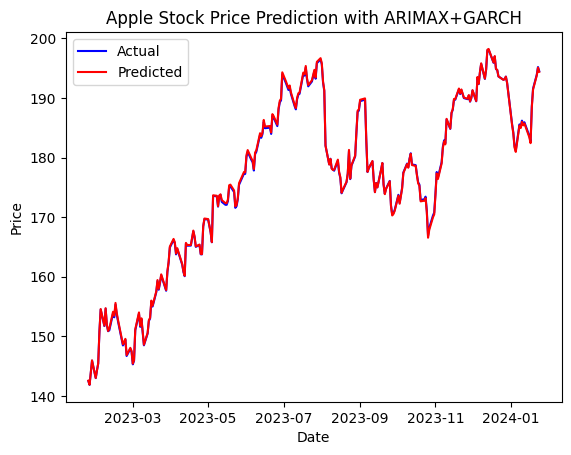

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from arch import arch_model

# Load Apple stock price data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Add exogenous variables for the events
data['Settlement_Royalty_Dispute'] = np.where(data.index == '2019-04-17', 1, 0)
data['Trade_Tensions_Escalation'] = np.where(data.index == '2019-06-28', 1, 0)
data['US_China_Trade_Concerns'] = np.where(data.index == '2019-12-09', 1, 0)
data['Strong_Earnings_Report'] = np.where(data.index == '2020-07-29', 1, 0)
data['Disappointment_Over_iPhone_Sales'] = np.where(data.index == '2021-03-16', 1, 0)
data['iPhone_13_Launch_Delay'] = np.where(data.index == '2021-07-01', 1, 0)
data['Class_Action_Lawsuit'] = np.where(data.index == '2022-01-31', 1, 0)
data['Supply_Chain_Challenges'] = np.where(data.index == '2022-05-04', 1, 0)
data['US_China_Semiconductor_Curbs'] = np.where(data.index == '2022-09-12', 1, 0)
data['Technology_Sector_Gains'] = np.where(data.index == '2023-07-28', 1, 0)
data['Subdued_Holiday_Quarter_Forecast'] = np.where(data.index == '2023-10-26', 1, 0)
data['Return_of_Huawei_and_Foldable_Phones'] = np.where(data.index == '2024-01-17', 1, 0)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Fit ARIMAX model
exog_train = train.drop(columns=['Close'])
exog_test = test.drop(columns=['Close'])

model = ARIMA(train['Close'], exog=exog_train, order=(1, 2, 2))
arimax_model = model.fit()

# Predictions
predictions = arimax_model.forecast(steps=len(test), exog=exog_test)

# Extract residuals from ARIMAX model
residuals = arimax_model.resid

# Fit GARCH model to residuals
garch_model = arch_model(residuals, vol='Garch', p=2, q=1)
garch_result = garch_model.fit()

# Forecast volatility using GARCH model
garch_forecast = garch_result.forecast(horizon=len(test))

# Incorporate GARCH volatility into predictions
volatility_forecast = garch_forecast.variance.values[-1, :] ** 0.5
predictions += volatility_forecast

# Evaluate ARIMAX+GARCH model
error = mean_squared_error(test['Close'], predictions)
print('ARIMAX+GARCH Mean Squared Error:', error)

# Visualize predictions
plt.plot(test.index, test['Close'], color='blue', label='Actual')
plt.plot(test.index, predictions, color='red', label='Predicted')
plt.title('Apple Stock Price Prediction with ARIMAX+GARCH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()